1. Importing the libraries that are needed for creating the machine learning model

    - "numpy" - used for working with arrays
    - "pandas" -  used for data manipulation and analysis
    - "keras" - Python interface for ANN
    - "sklearn" - used for machine learning and statistical modeling (including classification)
    - "matplotlib" -  used for plotting 
    - "random" -  to generate random variables
    - "os" to interact with the operating system


In [1]:
import numpy as np
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

2. Defining the image properties

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

3. Using the "os.listdir" function, the algorithm get the list of filenames from the train folder
   It then checks the name of the file before the '.' and assigns a value - 1 if the name of the file is dog or 0 if it is a cat
   Then, a dataframe is created, containing the filenames and their labels

In [3]:
filenames=os.listdir('./train/')
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

4. Using Keras, the CNN (convolutional neural network) is defined. The Sequential class is used for creating the model and the layers are added to the network using the "add()" function. 
   The first layer of the CNN is created, having 32 filters, a kernel size of (3,3) and ReLu activation function. The parameters of the input shape are the image width, shape and channels. 
   The BatchNormalization is added for normalizing the activations of the previous layer. 
   The MaxPooling2D is being used to downsample the spatial dimension od the previous layer and taking into account only a 2x2 pooling window. 
   The Dropout layer is added to avoid the overfitting, that will set 25% of the input units to 0 randomly. 
   The next two layers are unsig 128 and 512 filters, respectively, followed by the Flatten function to flatted the 2D tensor to 1D tensor. 
   The following step is to add a dense layer with 512 filters and ReLu activation, followed again by a BatchNormalization function. 
   The next Dropout layer is set to 50% to avoid overfitting. 
   Then, the next Dense layer is aded with 2 units and 'softmax' activation. 
   In the end, the model is complied using the 'categorical_crossentropy' loss function, the RMSprop and the accuracy metric.
   The final layer will also produce the output with 2 units and it will provide the probability of an image belonging to one of the two classes, cats or dogs.  


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

5. The model's summary will output a summary of the layers, shapes of the outputs and the numbers of the parameters in each layer and in the model. 
   It will also show the number of trainable parameters (weights, biases of the layers) and the number of non-trainable parameters (the moving mean, the variance in a normalization layer).

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

6. In order to improve the stability and the performance of the training, we are using EarlyStopping and ReduceLROnPlateau (callbacks). 
   The EarlyStopping is will stop the training process when the when the performance on a validation set will stop improving. In our case, the patience is set to 10, which means that the model will wait for ten epochs and if the performance (accuracy) will stop improving after ten ephocs, the training will be stopped. 
   The ReduceLROnPlateau will decrease the learning rate when the performace of the model on a validation set will stop improving. The factor is determing by how much the learning rate will be decreased and the min_lr is setting the minimum value to which the learning rate can go to. 
   The purpose of the two callbacks is to avoid overfitting of the model. They are basically stopping the model when the learning stops. 

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

7. In the dataframe that was created in a previous steps, the labels, 0 and 1, are being replaced by the names of the labels, cat and dog, respectively. 
   Then, using the train_test_split function, the test part is set to 20% of the data that will be used for validation purposes of the model. 
   The random state is controlling the randomness of the split to 42, which is making sure that each time we run the code, the results will be similar. 
   The indexes of the train and validation dataframes are reset and they will be assigned continuously. 
   Then, the number of rows in the test and validation dataframes are being added to the totals. 
   The batch size was set to 15, which means that in each iteration of the training process, 15 images will be used. 

In [7]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

8. This section of the model is creating image generators for the train, validation and test stages. 
   For the train image generator, the images are normalized by division with 255. 
   The train generator is taking the folder where the training images are stored and the dataframe where the labels are stored as input. The target size and the class mode are used to configure the generator.
   The target size is defining the size of the images so that they will be standardized and the class_mode is set to categorical, as the model is a binary classification one. 
   The characteristics for the validation datagenerator and validation generator are similar. 
   For the test generator, however, the class_mode is set to none, as there are no labels for the data just yet.  

In [8]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 './train/',x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    './train/', 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_filenames = os.listdir('./test1/')
test_df = pd.DataFrame({
'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_datagen = ImageDataGenerator(rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

test_generator = test_datagen.flow_from_dataframe(test_df,
'./test1/',x_col='filename',y_col=None,
target_size=Image_Size,
class_mode=None,
batch_size=batch_size)



Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


9. The fit_generator function is used to train and validate the model.
   The train_generator is used to feed the training data into the model. Then, the number of epochs is set - how many times the model will itterate through the test set. 
   The validation_data is proving the validation data to the model. The validation steps is setting the number of batches to be used for validation before moving further to the next epoch. 
   The steps per epoch represents the number of steps to be made during each epoch. 
   The callbacks are applied at the end of each epoch. 

In [9]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\gsimion\AppData\Local\Temp\ipykernel_31464\2528005629.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
1333/1333 [==============================] - 340s 254ms/step - loss: 0.7449 - accuracy: 0.6361 - val_loss: 0.5530 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 337s 253ms/step - loss: 0.5428 - accuracy: 0.7371 - val_loss: 0.5778 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 341s 256ms/step - loss: 0.4860 - accuracy: 0.7716 - val_loss: 0.4539 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 347s 261ms/step - loss: 0.4562 - accuracy: 0.7911 - val_loss: 0.3807 - val_accuracy: 0.8344 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 346s 259ms/step - loss: 0.4178 - accuracy: 0.8131 - val_loss: 0.3727 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 354s 265ms/step - loss: 0.4026 - accuracy: 0.8181 - val_loss: 0.3863 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 7/10
1333/1333 [============

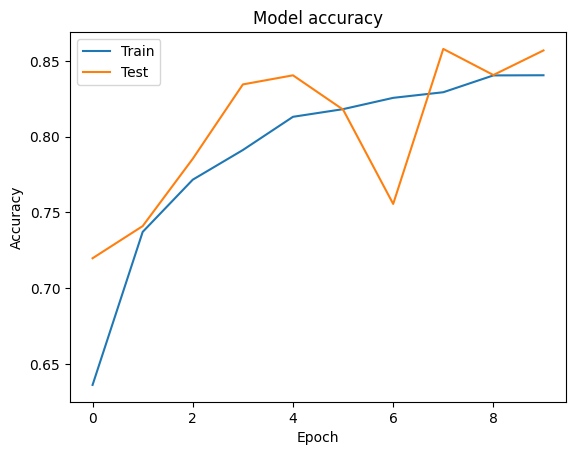

In [10]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

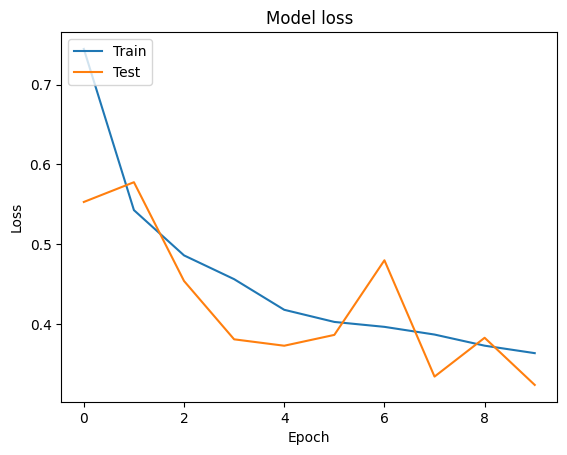

In [11]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

10. Saving the model.

In [12]:
model.save("model1_catsVSdogs_10epoch.h5")

11. The number of rows in the test_df is assigned to the nb_samples variable. The shape attribute is returning a tuple consisting of the number of rows and the number of columns. The test_df.shape[0] is accessing the first element of the tuple, more precisely, the number of rows.

In [13]:

nb_samples = test_df.shape[0]

12. The predict method is being used on the test_generator, the number of iterations that the model should go through while making predictions being the number of samples divided by the batch size.

In [14]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))


834/834 [==============================] - 55s 66ms/step


13. Once the predictions on the test dataset are being made, the label is being added in the 'category' column. 
    The binary labels are then replaced by the actual name of the labels, 'dog' for 1 and 'cat' for 0.

In [15]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

14. The next section is displaying a sample of the test data together with the label that is being assigned by the prediction.

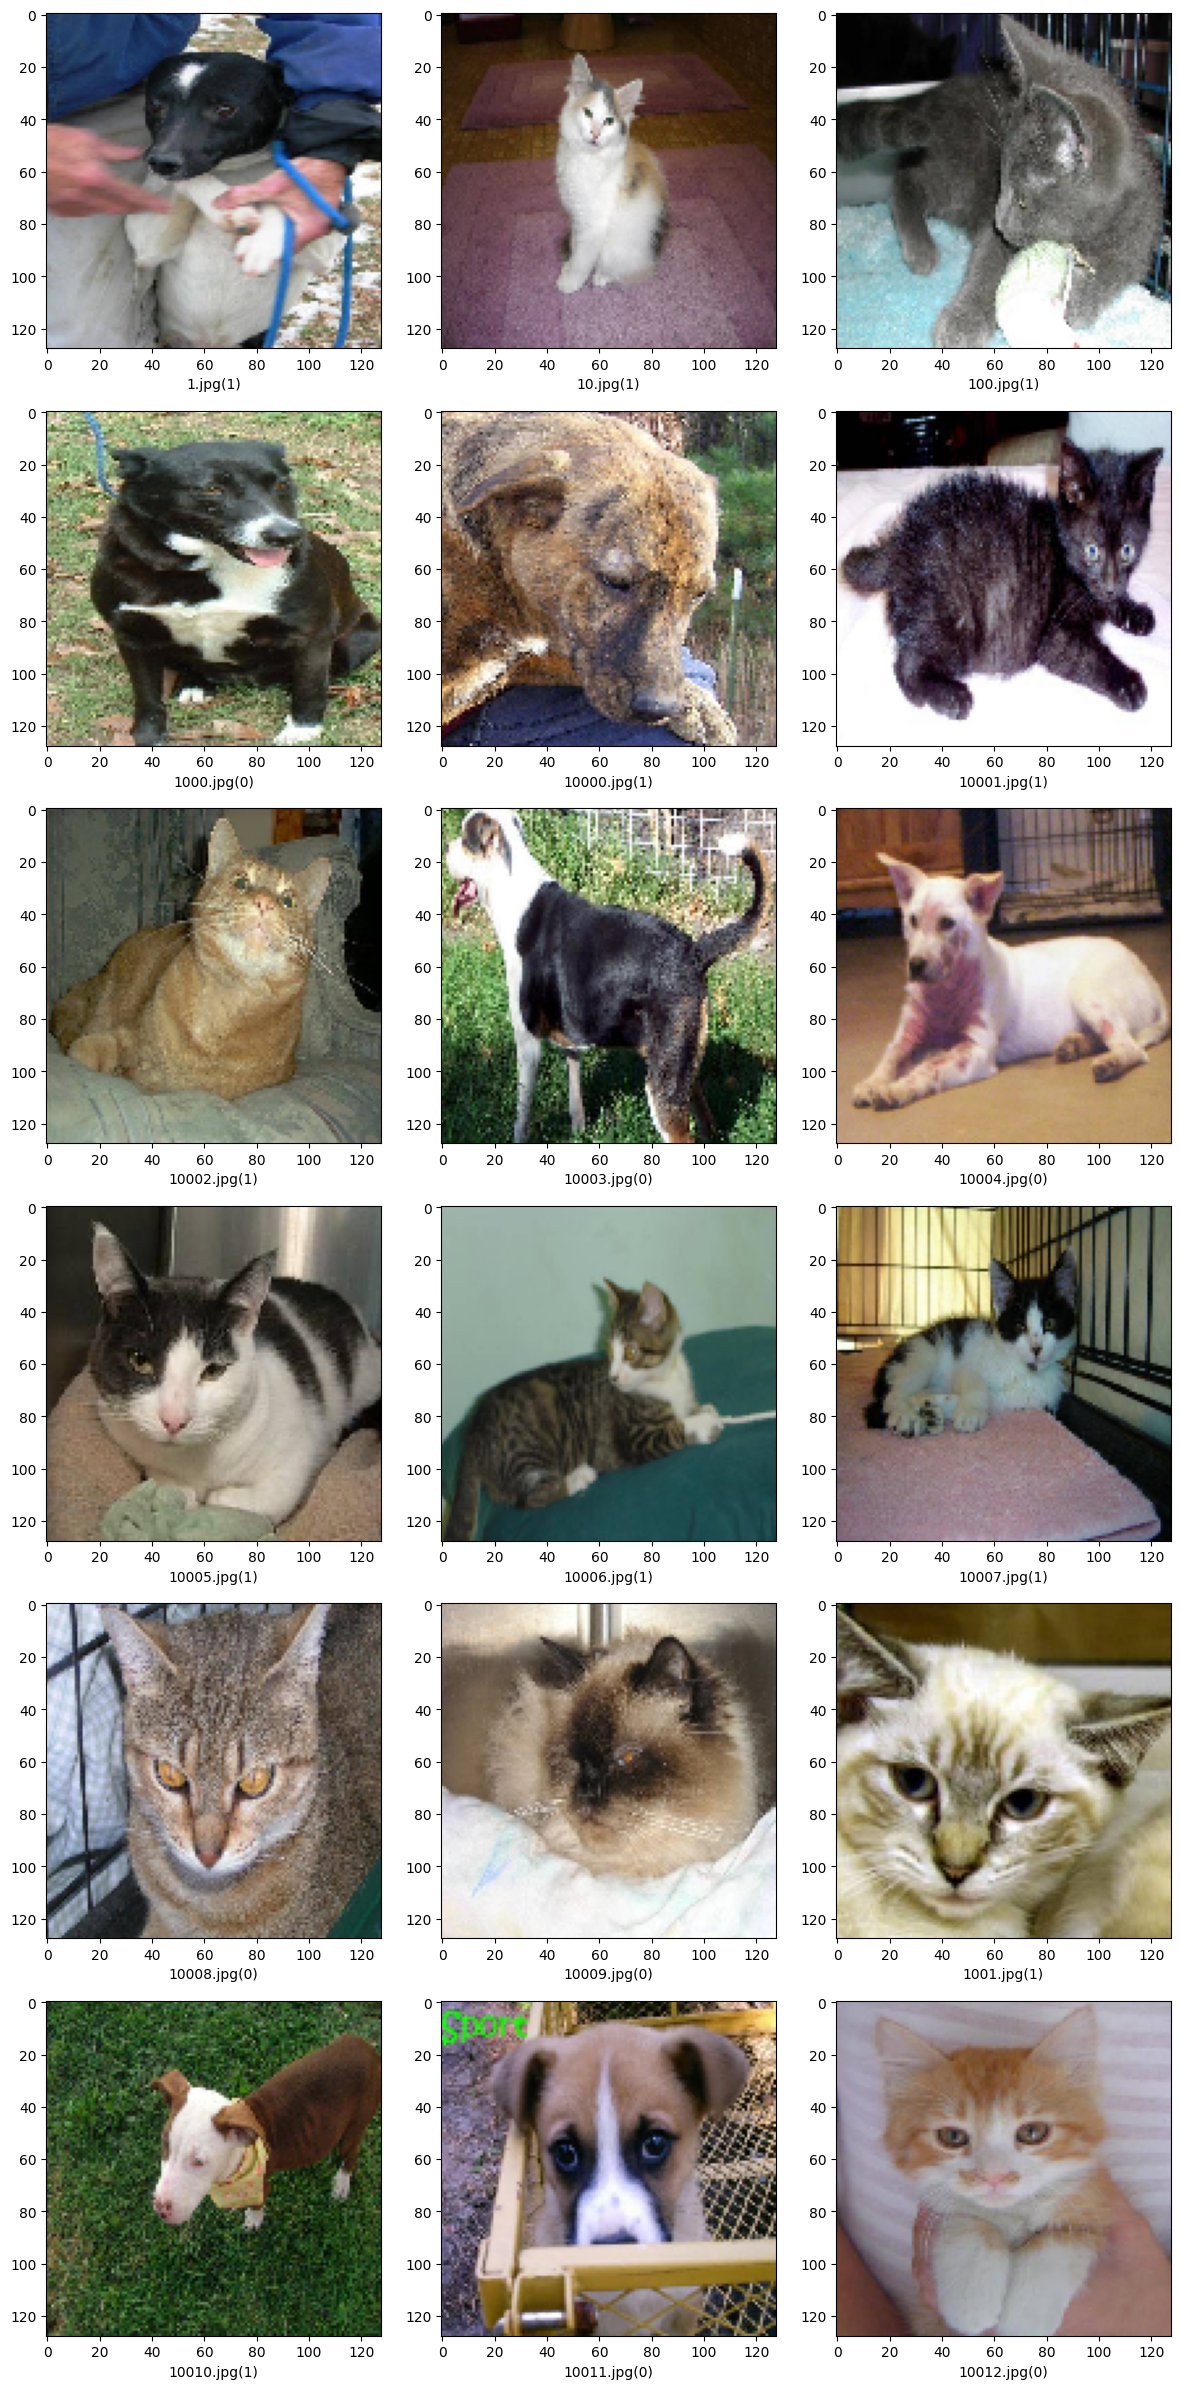

In [16]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

15. In the last part, certain images are being fed to the machine learning model and it displays the predicted result. 

In [17]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("./test1/2.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=np.round(model.predict(im)[0][1])
print(pred,results[pred])

1/1 [==============================] - 0s 35ms/step
1.0 dog


In [20]:

results={0:'cat', 1:'dog'}
im=Image.open("./test1/27.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred= np.argmax(model.predict(im))
print(pred,results[pred])






1/1 [==============================] - 0s 25ms/step
1 dog
